In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np
import torch

sys.path.insert(0, '..')
from isegm.utils import vis, exp

from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample

device = torch.device('cuda:2')
cfg = exp.load_config_file('./config.yml', return_edict=True)

/home/suhohan/anaconda3/envs/ritm/lib/python3.10/site-packages/skimage/measure/_label.py:1: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy import ndimage


### Init dataset

In [2]:
datasets = []
# DATASET = ['GrabCut', 'Berkeley', 'DAVIS', 'BraTS']
DATASET = 'BraTS'
dataset = utils.get_dataset(DATASET, cfg)
dataset.__len__()

Loading files: 100%|██████████| 900/900 [00:00<00:00, 2410.89it/s]


900

### Init model

In [3]:
from isegm.inference.predictors import get_predictor
import os

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(os.path.join(
    './experiments/hrnet32_brats_itermask/', '032_loss-fixed/checkpoints/'), '180.pth')
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

### Dataset evaluation

In [4]:
TARGET_IOU = 0.9
all_ious, elapsed_time = evaluate_dataset(dataset, predictor, pred_thr=MODEL_THRESH,
                                          max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)
mean_spc, mean_spi = utils.get_time_metrics(all_ious, elapsed_time)
noc_list, over_max_list = utils.compute_noc_metric(all_ious,
                                                   iou_thrs=[0.8, 0.85, 0.9],
                                                   max_clicks=EVAL_MAX_CLICKS)
header, table_row = utils.get_results_table(noc_list, over_max_list, brs_mode, DATASET,
                                            mean_spc, elapsed_time, EVAL_MAX_CLICKS)
print(header)
print(table_row)

900


  0%|          | 0/900 [00:00<?, ?it/s]

/home/suhohan/pytorch-ritm/isegm/inference/utils.py:78: RuntimeWarning: invalid value encountered in long_scalars
  return intersection / union


-----------------------------------------------------------------------------------------------
|  BRS Type   |  Dataset  | NoC@80% | NoC@85% | NoC@90% |>=20@85% |>=20@90% | SPC,s |  Time   |
-----------------------------------------------------------------------------------------------
|   f-BRS-B   |   BraTS   |  20.00  |  20.00  |  20.00  |   900   |   900   | 0.016 | 0:04:47 |


### Single sample eval

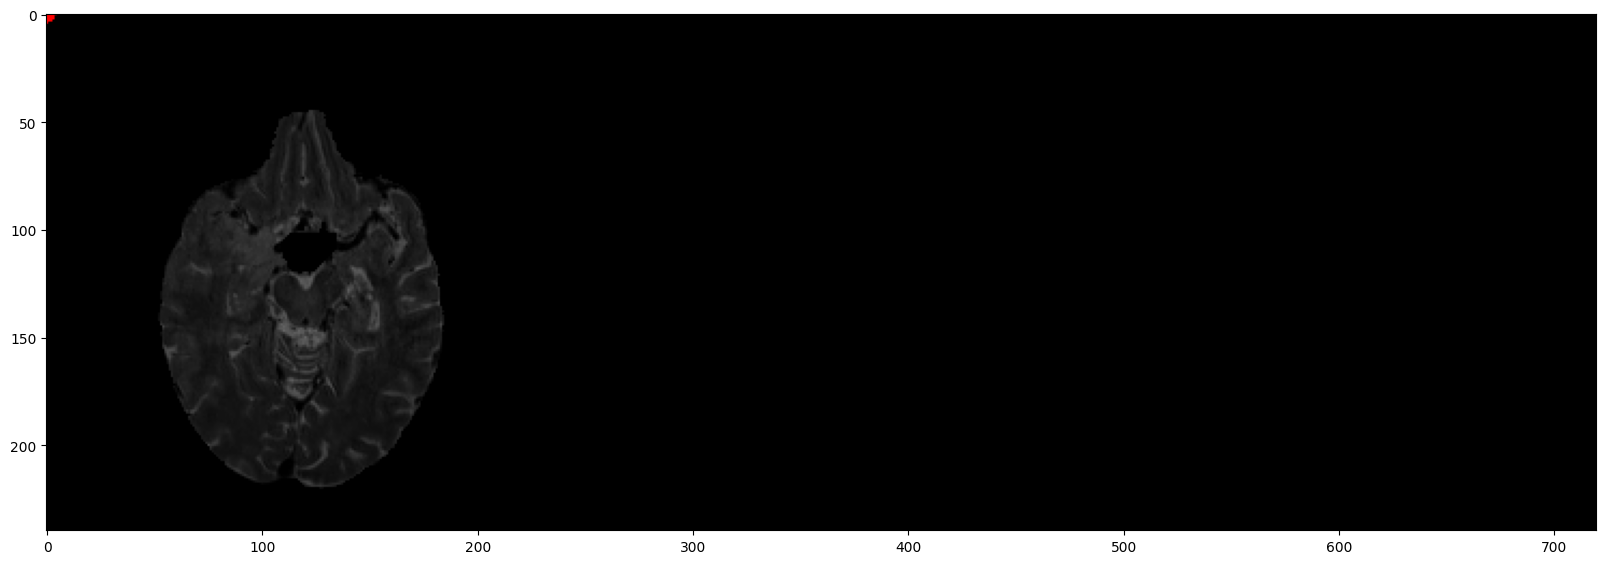

Dice Score: 1.0000
Required Clicks: 20


In [14]:
sample_id = 100
TARGET_IOU = 0.9
EVAL_MAX_CLICKS = 20
sample = dataset.get_sample(sample_id)
gt_mask = sample['label']

clicks_list, ious_arr, pred = evaluate_sample(sample['image'], gt_mask, predictor,
                                              pred_thr=MODEL_THRESH,
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)

pred_mask = pred > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample['image'], mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
                       255 * pred_mask[np.newaxis, :, :].repeat(3, axis=0),
                       255 * gt_mask[np.newaxis, :, :].repeat(3, axis=0)
                       ), axis=2)
draw = draw.transpose(1, 2, 0)
plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()

pred_mask = pred_mask.astype(bool)
gt_mask = gt_mask.astype(bool)

true_positive = np.sum(pred_mask & gt_mask)

pred_sum = np.sum(pred_mask)
gt_sum = np.sum(gt_mask)

if (pred_sum + gt_sum) == 0:
    dice = 1.0
else:
    dice_coeff = 2 * true_positive / (pred_sum + gt_sum)
    dice = dice_coeff

print(f"Dice Score: {dice:.4f}")
print(f"Required Clicks: {len(clicks_list)}")

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


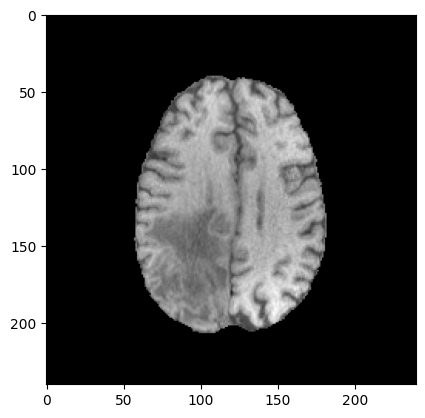

In [11]:
plt.imshow(sample['image'].transpose(1, 2, 0))